In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor
from convexmtl_torch.model.GraphLaplacianMTLPytorchModel import GraphLaplacianMTLPytorchRegressor

from convexmtl_torch.model.utils import NeuralNetwork

from sklearn.model_selection import GridSearchCV

from convexmtl_torch.data.MTLSyntheticDataset import MTLCommonRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy

from utils import train_gs

import random


In [2]:
max_epochs=50
log_every_n_steps=10
problem = 'common'

In [3]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
mtlds = MTLCommonRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 1, 2]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             2: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)}
ic| X_data.shape: (300, 1)


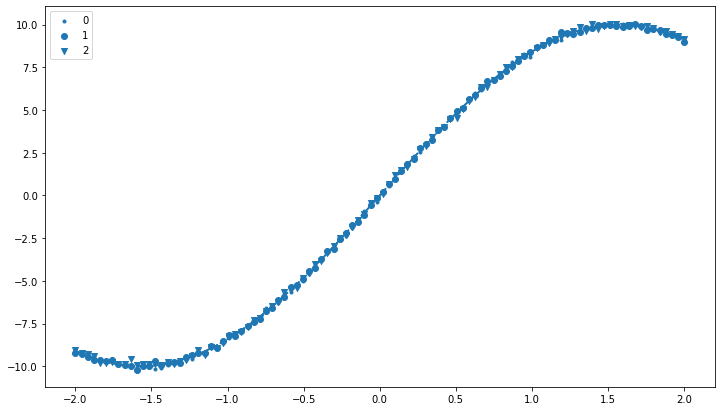

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train.shape

(201, 2)

## GraphLaplacian Torch

In [8]:
max_epochs=50

In [9]:
model = GraphLaplacianMTLPytorchRegressor(adj_trainable=True, train_mode='lightning', epochs=max_epochs, nu=0.1, mu=0.05, adj_lr=1e-2, val_size=0, batch_size=32)
model

GraphLaplacianMTLPytorchRegressor(adj_lr=0.01, adj_trainable=True,
                                  batch_size=32, epochs=50, mu=0.05, nu=0.1,
                                  val_size=0)

In [10]:
model.fit(X_train, y_train)

ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 1.3806e+00, Tr:1.38(1.38), V:N/A: 100%|██████████| 50/50 [00:01<00:00, 41.02it/s]   


In [11]:
pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.1902053957779664

In [12]:
wd_l = [10**(k) for k in range(-2, -1)]
adjlr_l = [10**(k) for k in range(-3, 0)]

params = {
    'weight_decay' : wd_l,
    # 'adj_lr' : adjlr_l,
}

In [13]:
gs = train_gs(model, params, X_train, y_train, model_name='glmtlNN', problem_name=problem, scoring='neg_mean_squared_error', retrain=True)
gs

ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 1.7853e+00, Tr:1.79(1.79), V:N/A: 100%|██████████| 50/50 [00:00<00:00, 56.86it/s]   
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 2.6198e+00, Tr:2.62(2.62), V:N/A: 100%|██████████| 50/50 [00:00<00:00, 60.81it/s]   
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 2.1162e+00, Tr:2.12(2.12), V:N/A: 100%|██████████| 50/50 [00:00<00:00, 54.66it/s]   
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 2.2329e+00, Tr:2.23(2.23), V:N/A: 100%|██████████| 50/50 [00:00<00:00, 52.23it/s]   
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 1.4955e+00, Tr:1.50(1.50), V:N/A: 100%|██████████| 50/50 [00:00<00:00, 58.03it/s]   
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss: 1.4736e+00, Tr:1.47(1.47), V:N/A: 100%|██████████| 50/50 [00:01<00:00, 45.76it/s]   


GridSearchCV(estimator=GraphLaplacianMTLPytorchRegressor(adj_lr=0.01,
                                                         adj_trainable=True,
                                                         batch_size=32,
                                                         epochs=50, mu=0.05,
                                                         nu=0.1, val_size=0),
             param_grid={'weight_decay': [0.01]},
             scoring='neg_mean_squared_error')

In [14]:
# pred = model(X_test, t_test)
pred = gs.predict(X_test)

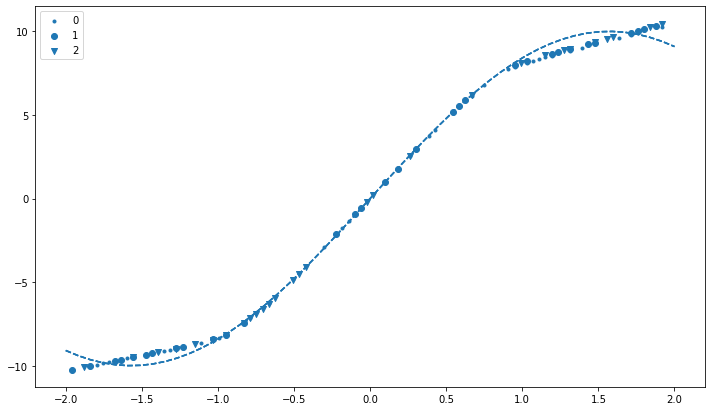

In [15]:
mtlds.plot_data_functions(X_test, pred)

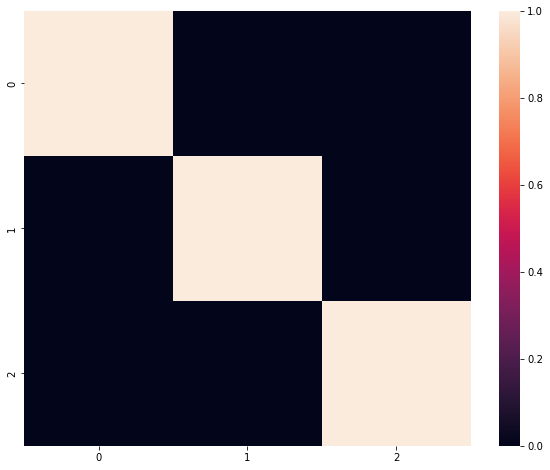

In [16]:
adjMatrix = gs.best_estimator_.model.get_fig_adjMatrix()
plt.show()

## Tensorboard

In [17]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/